In [0]:
import pandas as pd
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import gc

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Loading data

chunksize=10**6
names = ('c0', 'Name', 'Date', 'Time', 'Time, mcs.', 'c1' ,'Price', 'c2', 'Dir','c3','Amount')
usecols = ('Name','Date','Time','Time, mcs.','Price','Dir','Amount')
data=np.array([])
for chunk in pd.read_csv(
                'trades.txt,'#'/content/drive/My Drive/trades.txt', 
                chunksize=chunksize, sep=' ', 
                names=names, usecols=usecols):
    data=np.append(data, chunk.to_numpy())
indexes=np.arange(len(data))
l=int(len(data)/7)
data=data.reshape((l,7))

# Task 1: Checking function

In [0]:
# Functions(run this cell for new case)



#return mask for condition
def condition(x,value):
  if (x == value):
    return True
  else:
    return False
case=np.vectorize(condition)

# Return np.array of string-elements' lengths
len_strs=np.vectorize(len)

#returns month as integer
def mono(date):
  return date[3:5]
slice_month = np.vectorize(mono)

#returns day as integer
def da(date):
  return date[6:8]
slice_day=np.vectorize(da)

#check points for expiration
@jit(nopython=True)
def expiration(i):
  start=months[(times<=min10[i])&(times>=case_times[i])][-1]
  end=months[(times<=min10[i])&(times>=case_times[i])][0]
  if (start != end):
    return False
  return True
check = np.vectorize(expiration)



# return a price on j-minute for i-case_point
@jit(nopython=True)
def me_price(i, j):
  mint = case_times[i] + minutes[j]
  mask = (times>=mint-1000000)&(times<=mint+1000000)
  chunk = prices[mask]
  if chunk.size==0:
    return case_prices[i], 0, 0
  else:
    sells = len(mask[(mask)&(len_dirs==4)])
    buys  = len(chunk)-sells
    return chunk[0], sells, buys
me_case=np.vectorize(me_price, excluded=['j'])



def quant(case_prices, case_times, case_dates, case_ix, type_dir):
  #Check expiration
  dim = np.arange(len(case_times))
  mask=check(dim)

  gc.collect()

  # Return check-points
  case_prices=case_prices[mask]
  case_times=case_times[mask]
  case_dates=case_dates[mask]
  case_ix=case_ix[mask]
  number=len(case_ix)
  check_dim=np.arange(number)
  
  gc.collect()
  
  # Return prices for 1-10 minutes
  price_min=np.array([])
  sells_count=np.array([])
  buys_count=np.array([])
  for j in np.arange(10):
    x,y,z = me_case(i=check_dim, j=j)
    price_min=np.append(price_min, x)
    sells_count=np.append(sells_count, y)
    buys_count=np.append(buys_count, z)
    
  price_min=price_min.reshape((10,number))
  sells_count=sells_count.reshape((10,number))
  buys_count=buys_count.reshape((10,number))

  gc.collect()
  
  # Calculate means
  profit_means=np.array([])
  profit_means=np.append(profit_means, 0.0)
  for j in np.arange(10):
    if (type_dir=='BUY'):
      prof=case_prices-price_min[j]
    else:
      prof=price_min[j] - case_prices
    profit_means=np.append(profit_means, np.mean(prof))
  
  gc.collect()
  
  # Calculate stds
  profit_stds=np.array([])
  profit_stds=np.append(profit_stds, 0.0)
  for j in np.arange(10):
    if (type_dir=='BUY'):
      prof=case_prices-price_min[j]
    else:
      prof=price_min[j]-case_prices
    profit_stds=np.append(profit_stds, np.std(prof))
  
  gc.collect()
  
  # Calculate directions
  sum_sells=np.array([])
  sum_buys=np.array([])
  for j in np.arange(10):
    sum_sells=np.append(sum_sells, np.sum(sells_count[j]))
    sum_buys=np.append(sum_buys, np.sum(buys_count[j]))
    
  gc.collect()
  
  # Create tables
  columns=['1 minute', '2 minute', '3 minute', '4 minute', 
           '5 minute', '6 minute', '7 minute', '8 minute', '9 minute', '10 minute']
  Sells = pd.DataFrame(columns=columns, data=sum_sells.reshape((1,10)), index={'Sells'})
  Buys = pd.DataFrame(columns=columns, data=sum_buys.reshape((1,10)), index={'Buys'})
  
  # Drowing mean-plot
  t = np.arange(0, 11,1)
  means=profit_means

  fig, ax = plt.subplots()
  ax.plot(t, means, marker='o', markersize=10, linewidth=3, color='black')
  plt.rc('font', size=24)
  
  ax.set(xlabel='Minute', ylabel='Mean', title='Trading Idea')
  ax.grid()
  ax.set_xticks(np.arange(len(t)))
  fig.set_size_inches(18.5, 10.5)
  
  fig.savefig("means.png")
  #plt.show()
  
  # Drowing std-plot
  t = np.arange(0, 11,1)
  stds=profit_stds

  fig, ax = plt.subplots()
  ax.plot(t, stds, marker='o', markersize=10, linewidth=3, color='black')
  plt.rc('font', size=24)

  ax.set(xlabel='Minute', ylabel='Std', title='Trading Idea')
  ax.grid()
  ax.set_xticks(np.arange(len(t)))
  fig.set_size_inches(18.5, 10.5)

  fig.savefig("stds.png")
  #plt.show()
  return Sells, Buys

In [0]:
# Prepare a data
n = len(usecols)
names=data[:,0].astype('U6')
dates=data[:,1].astype('U8')
sep_times=data[:,2].astype('U8')
times=data[:,3].astype('int64')
prices=data[:,4].astype('float32')
directions=data[:,5].astype('U5')
amounts=data[:,6].astype('int32')
ix=np.arange(len(dates))
months=slice_month(dates).astype('int8')
len_dirs=len_strs(directions) #lens of directions

gc.collect()

# Task 2: Pilot idea

In [0]:
# Find points for case

minutes=np.arange(start=1, stop=11)
minutes*=6*10**7

#"""
case_prices=prices[(directions=='BUY')&(amounts==1000)]
case_times=times[(directions=='BUY')&(amounts==1000)]
case_dates=dates[(directions=='BUY')&(amounts==1000)]
case_ix=ix[(directions=='BUY')&(amounts==1000)]
#"""

min10=case_times+minutes[9] # for expiration

gc.collect()

In [0]:
number=5
dim=np.arange(5)
price_min=np.array([])
sells_count=np.array([])
buys_count=np.array([])
champ=np.array([])
means, stds, sum_sells, sum_buys = me_case(i=dim, j=np.arange(10), case_times=np.array(case_times), \
minutes=np.array(minutes), times=np.array(times),prices=np.array(prices), case_prices=np.array(case_prices), len_dirs=np.array(len_dirs))
#champ=champ.reshape((10, number, 3))
#price_min=champ[:,:,2]
#sells_count=champ[:,:,1]
#buys_count=champ[:,:,0]

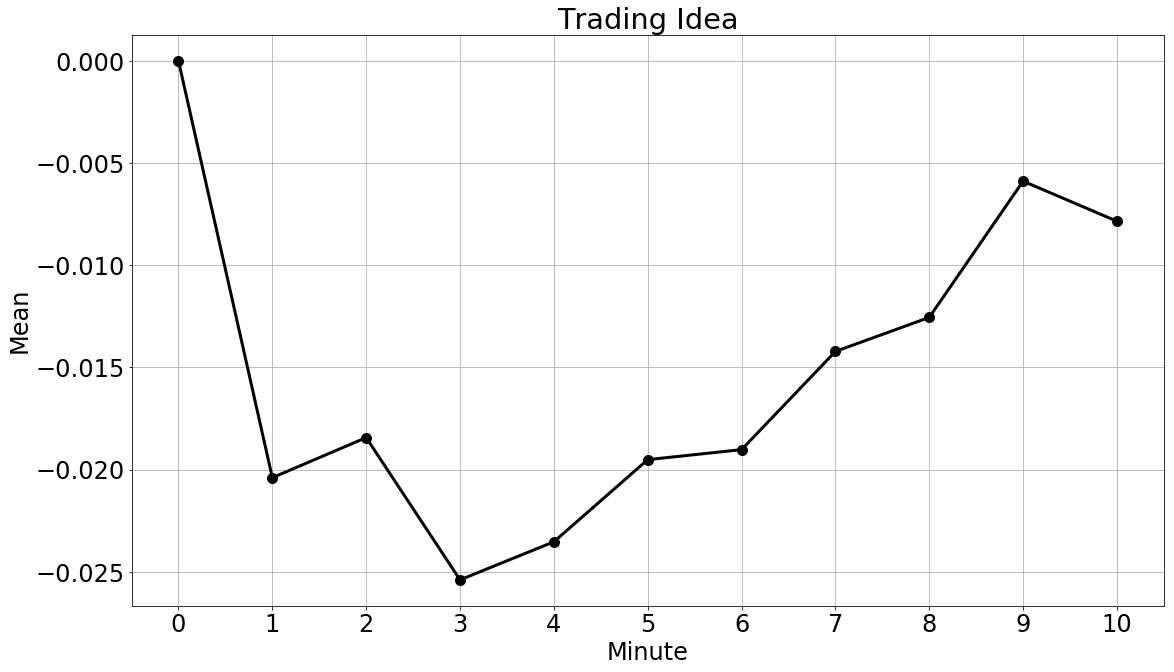

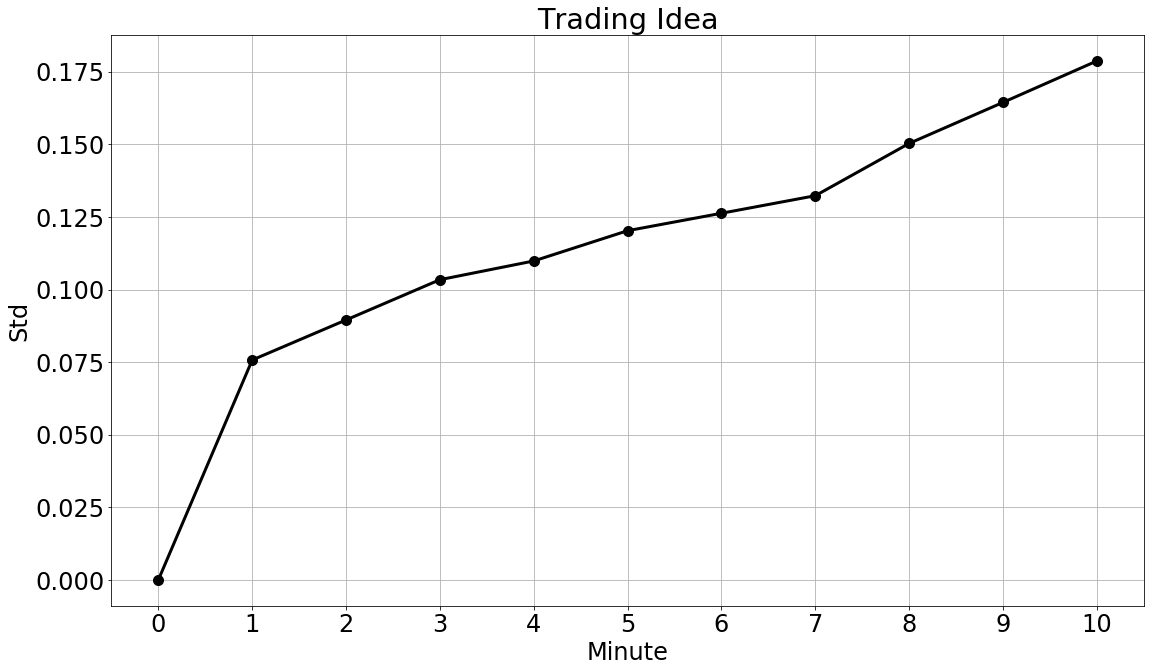

In [0]:
Sells, Buys = quant(case_prices=case_prices, case_times=case_times, 
                    case_dates=case_dates, case_ix=case_ix, type_dir='BUY') 
                    #prices=prices, times=times, dates=dates, months=months, min10=min10, minutes=minutes)

In [0]:
Sells

,1 minute,2 minute,3 minute,4 minute,5 minute,6 minute,7 minute,8 minute,9 minute,10 minute
Sells,722.0,761.0,481.0,551.0,580.0,376.0,293.0,532.0,655.0,335.0


In [0]:
Buys

,1 minute,2 minute,3 minute,4 minute,5 minute,6 minute,7 minute,8 minute,9 minute,10 minute
Buys,750.0,706.0,796.0,589.0,465.0,379.0,360.0,439.0,310.0,254.0


# Task 3: Trading Ideas

# Idea 1

*Let's check correlation between amounts and prices of sells:*

In [0]:
check_price=prices[directions=='SELL']
check_amount=amounts[directions=='SELL']
np.corrcoef(check_price, check_amount)

array([[ 1.        , -0.03500459],
       [-0.03500459,  1.        ]])

*Negative correlation between 'prices' and 'amounts' proves that ticks with great amounts usually have smaller prices than average price.*

*Now, let's find a mean price of sells which have amounts greater than 1000:*

In [0]:
mean_price_1000 = np.mean(check_price[check_amount>=1000])
gc.collect()
mean_price_1000

72.47976

*And find same for sells with lower than 1000 amounts:* 

In [0]:
mean_price_low=np.mean(check_price[check_amount<1000])
gc.collect()
mean_price_low

74.648766

*So, the difference between means is 2.169006.*

**Idea**: *Get one lot towards to sells with greater than 1000 amounts.*
 
*Will it be profitable?*

**Let's find out!**

In [0]:
# Find points for case

minutes=np.arange(start=1, stop=11)
minutes*=6*10**7 # for plots


case_prices=prices[(directions=='SELL')&(amounts>=1000)]
case_times=times[(directions=='SELL')&(amounts>=1000)]
case_dates=dates[(directions=='SELL')&(amounts>=1000)]
case_ix=ix[(directions=='SELL')&(amounts>=1000)]

min10=case_times+minutes[9] # for expiration

gc.collect()

#P.S.: Don't forget to rerun cell with functions!

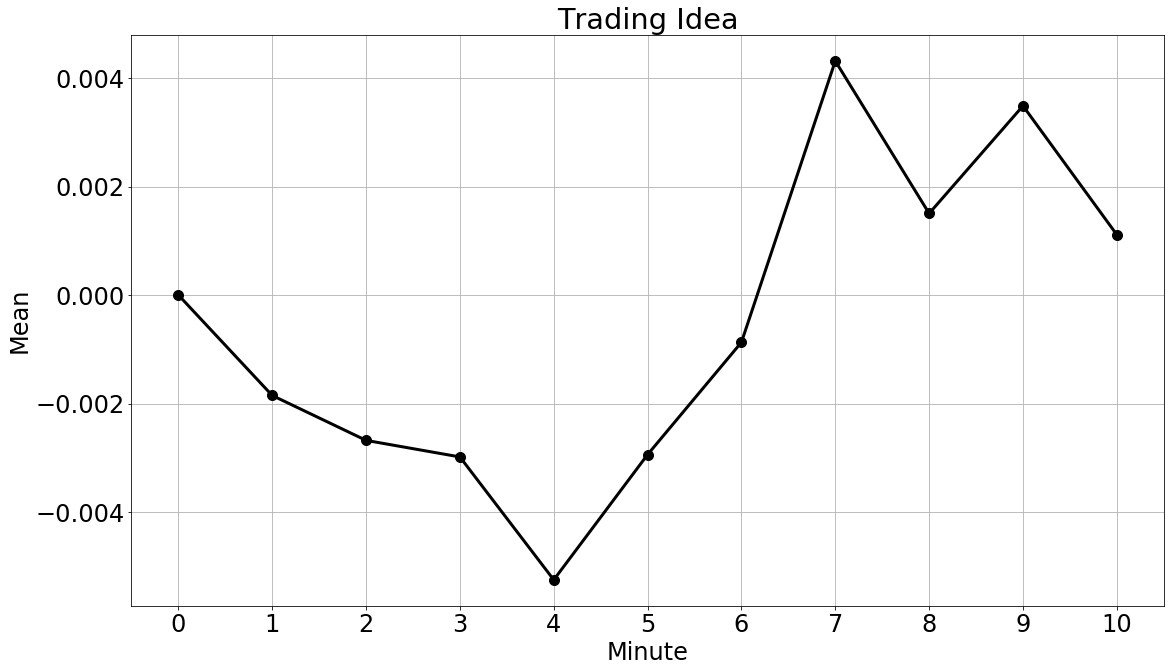

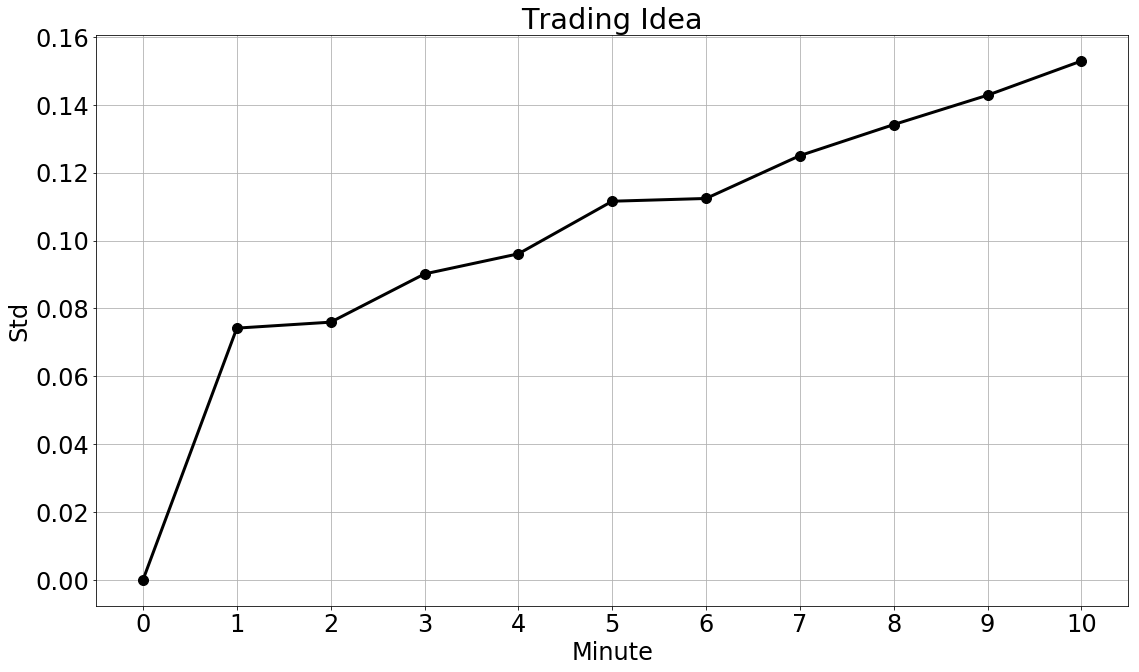

In [0]:
# use quant function
Sells, Buys = quant(case_prices=case_prices, case_times=case_times, case_dates=case_dates, case_ix=case_ix, type_dir='SELL')

# Results 
*We have positive rate 0.04 on 7th minute, but it's still not enough.*


# Idea 2

*In my opinion, to get more income we should find points which differ from their neighbours pretty much.*
*Let's try to find these points with 'BUY' direction and with low price and not forget to avoid expiration episodes.*

In [0]:
# First, let's pop the end element of the prices-array 
past_prices=prices[:-1]

#Second, insert prices[0]-element on the zero position
past_prices=np.insert(past_prices, 0, past_prices[0])

#Checking
len(past_prices)==len(prices)

True

In [0]:
# Do same for directions
past_directions=directions[:-1]
past_directions=np.insert(past_directions, 0, past_directions[0])
len(past_directions)==len(directions)

True

In [0]:
#OK, now we need to create days' array with dtype='int8' for expiration checking
days=slice_day(dates).astype('int8')
# Transform to past days
past_days=days[:-1]
past_days=np.insert(past_days, 0, past_days[0])
len(past_days)==len(days)

In [0]:
#Let's find our points!

minutes=np.arange(start=1, stop=11)
minutes*=6*10**7 # for plots
price_deltas=prices-past_prices

mask=(directions=='BUY')&(past_directions=='BUY')&(days==past_days)&(price_deltas>0.069)

case_prices=prices[mask]
case_times=times[mask]
case_dates=dates[mask]
case_ix=ix[mask]

min10=case_times+minutes[9] # for expiration

gc.collect()

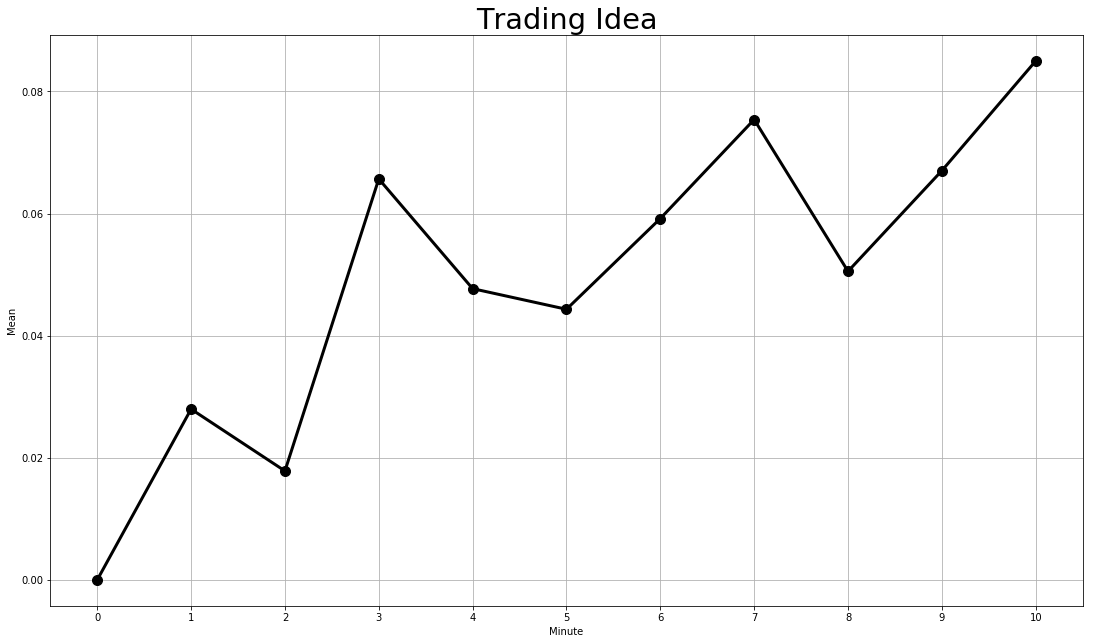

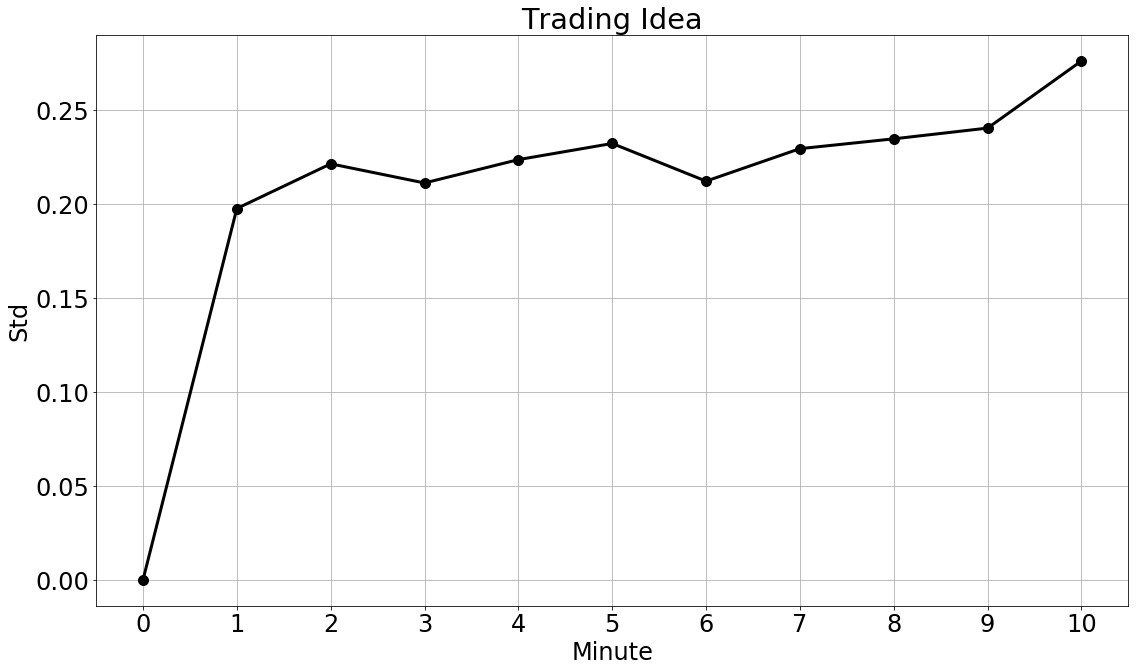

In [0]:
# use quant function and don't forget to rerun cell with functions before run this---->
Sells, Buys = quant(case_prices=case_prices, case_times=case_times, case_dates=case_dates, case_ix=case_ix, type_dir='BUY')

In [0]:
Sells

,1 minute,2 minute,3 minute,4 minute,5 minute,6 minute,7 minute,8 minute,9 minute,10 minute
Sells,1921.0,1659.0,825.0,566.0,935.0,582.0,952.0,420.0,420.0,903.0


In [0]:
Buys

,1 minute,2 minute,3 minute,4 minute,5 minute,6 minute,7 minute,8 minute,9 minute,10 minute
Buys,1556.0,1106.0,1097.0,480.0,860.0,610.0,1065.0,399.0,303.0,571.0


# Results

*As we supposed, this set of points turned out to be more profitable than previous. There're positive incomes along the all 10 minutes and the trend is positive too.*

# Idea 3

*Next, we also try to catch points with a huge price-gaps, but with 'SELL' direction.*

*To get a profit on sells, we need to find ticks with differences lower*
*than selected negative value.* 

*We will "buy" at the case point*
*and will sell on 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 minutes.*


In [0]:
# First, let's pop the end element of the prices-array 
past_prices=prices[:-1]

#Second, insert prices[0]-element on the zero position
past_prices=np.insert(past_prices, 0, past_prices[0])

# Do same for directions
past_directions=directions[:-1]
past_directions=np.insert(past_directions, 0, past_directions[0])

#OK, now we need to create days' array with dtype='int8' for expiration checking
days=slice_day(dates).astype('int8')
# Transform to past days
past_days=days[:-1]
past_days=np.insert(past_days, 0, past_days[0])



#Let's find our points!
minutes=np.arange(start=1, stop=11)
minutes*=6*10**7 # for plots
price_deltas=prices-past_prices

mask=(directions=='SELL')&(past_directions=='SELL')&(days==past_days)&(price_deltas<-0.069)

case_prices=prices[mask]
case_times=times[mask]
case_dates=dates[mask]
case_ix=ix[mask]

min10=case_times+minutes[9] # for expiration

gc.collect()

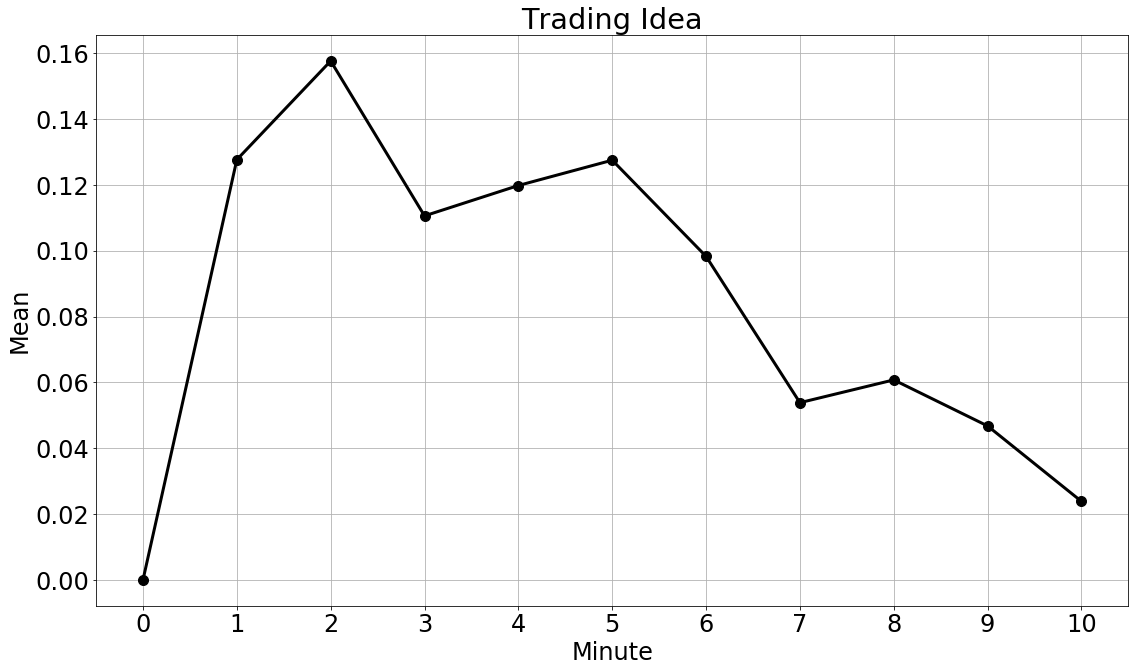

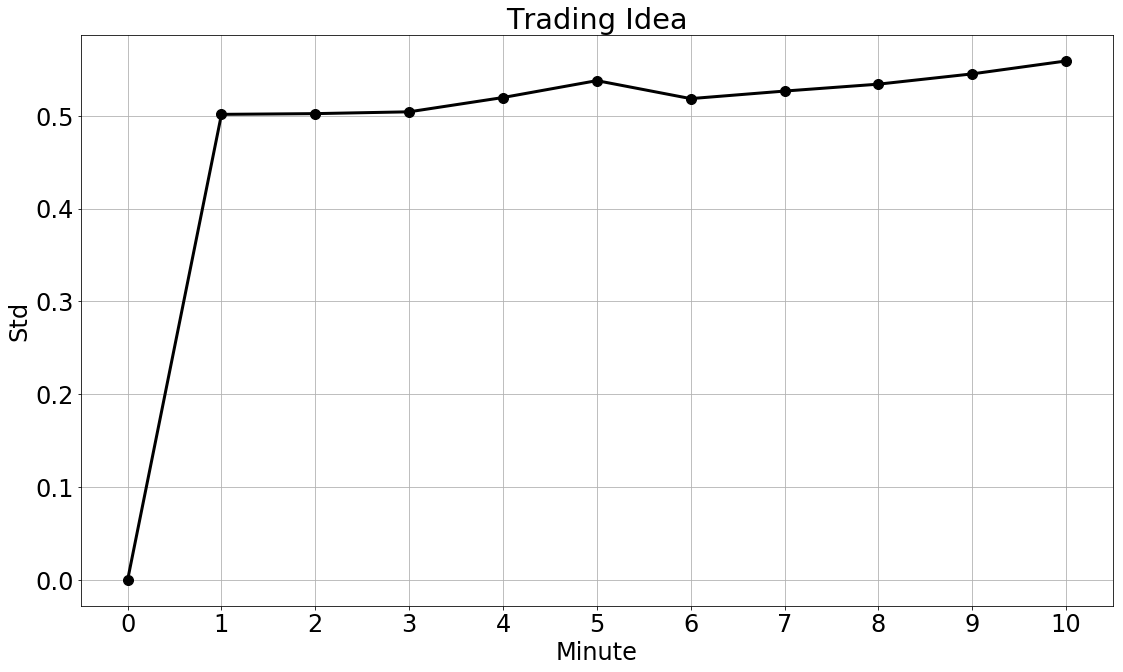

In [0]:
# use quant function and don't forget to rerun cell with functions before run this---->
Sells, Buys = quant(case_prices=case_prices, case_times=case_times, case_dates=case_dates, case_ix=case_ix, type_dir='SELL')

In [0]:
Sells

,1 minute,2 minute,3 minute,4 minute,5 minute,6 minute,7 minute,8 minute,9 minute,10 minute
Sells,1748.0,1403.0,1440.0,470.0,1187.0,613.0,630.0,599.0,308.0,770.0


In [0]:
Buys

,1 minute,2 minute,3 minute,4 minute,5 minute,6 minute,7 minute,8 minute,9 minute,10 minute
Buys,1527.0,1038.0,1225.0,810.0,1127.0,497.0,444.0,737.0,369.0,587.0


# Results

This case is also profitable pretty much, but in contrast to Idea 2 its trend is negative.

# Idea 4

*The amount of futures can be a perfect marker for trading.*

*For example, if have amount of 'buys' equals to 50 and
amount of 'sells' equals to 100.* 

*We can use ratio between them to get approximate demand and offer.*

**Let's check this idea for buys!**

*We should select points where buys-amount lower than sells-amount.*

*In this case we will be able to get a margin on selling bought futures.*

In [0]:
# First, let's pop the end element of the prices-array 
past_prices=prices[:-1]

#Second, insert prices[0]-element on the zero position
past_prices=np.insert(past_prices, 0, past_prices[0])

# Do same for directions
past_directions=directions[:-1]
past_directions=np.insert(past_directions, 0, past_directions[0])

# and for amounts
past_amounts=amounts[:-1]
past_amounts=np.insert(past_amounts, 0, past_amounts[0])

#OK, now we need to create days' array with dtype='int8' for expiration checking
days=slice_day(dates).astype('int8')
# Transform to past days
past_days=days[:-1]
past_days=np.insert(past_days, 0, past_days[0])



#Let's find our points!
minutes=np.arange(start=1, stop=11)
minutes*=6*10**7 # for plots
BpS=amounts/past_amounts

mask=(directions=='BUY')&(past_directions=='SELL')&(days==past_days)
bps_mask=(BpS<0.002) # price decrease

case_prices=prices[mask & bps_mask]
case_times=times[mask & bps_mask]
case_dates=dates[mask & bps_mask]
case_ix=ix[mask & bps_mask]

min10=case_times+minutes[9] # for expiration

gc.collect()

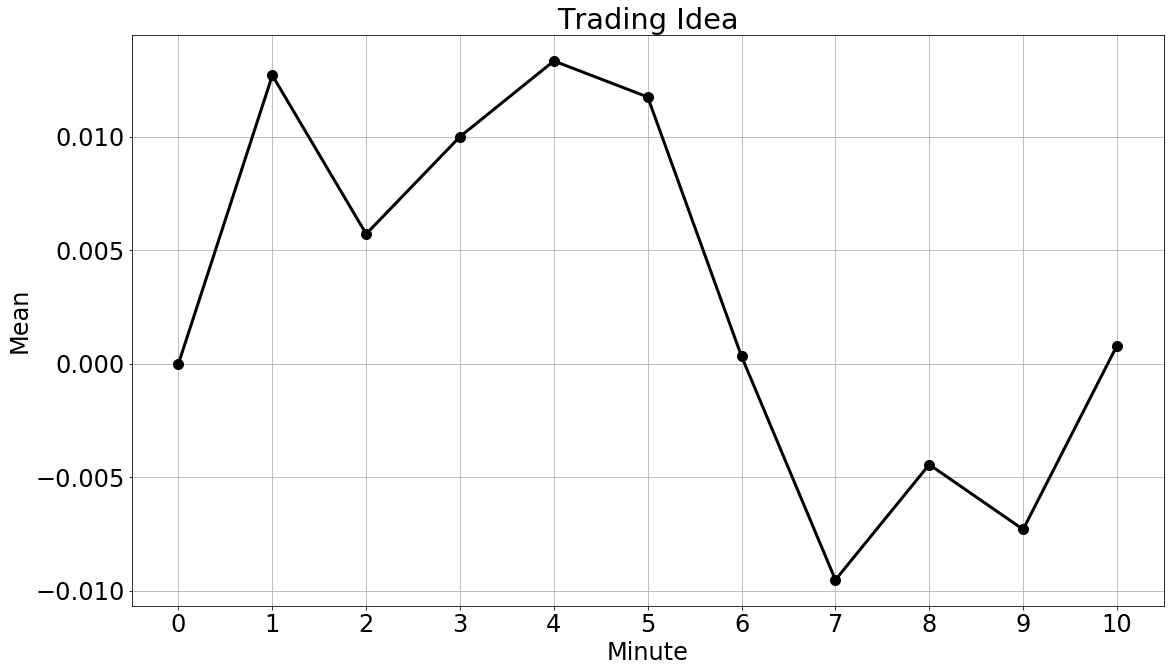

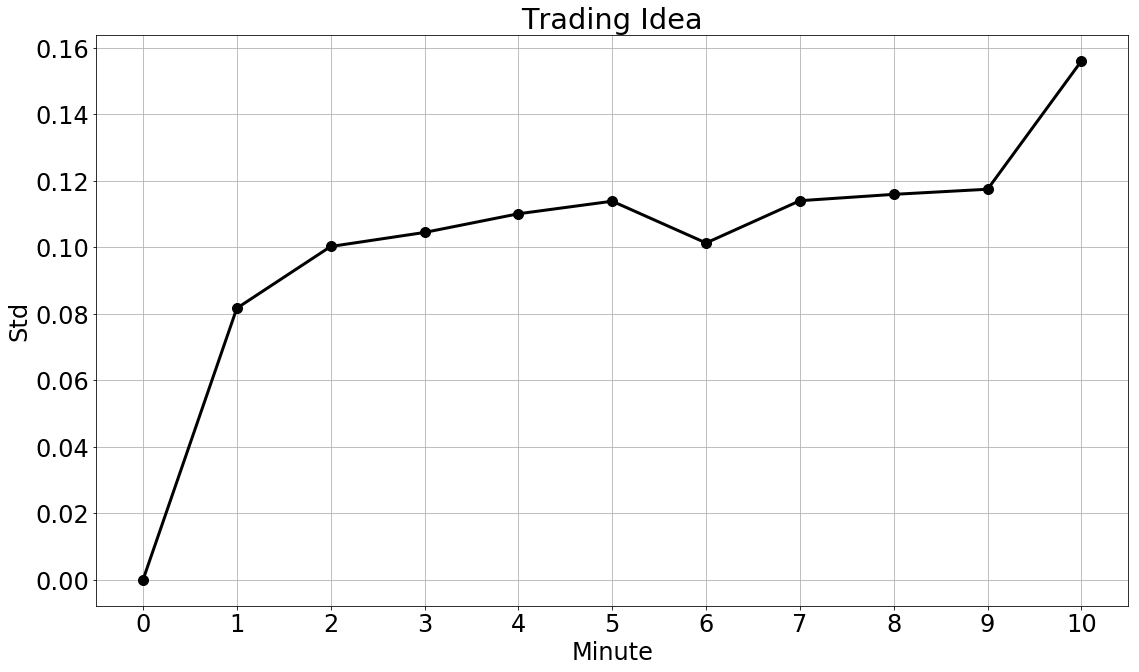

In [0]:
# use quant function and don't forget to rerun cell with functions before run this---->
Sells, Buys = quant(case_prices=case_prices, case_times=case_times, case_dates=case_dates, case_ix=case_ix, type_dir='BUY')

In [0]:
Sells

,1 minute,2 minute,3 minute,4 minute,5 minute,6 minute,7 minute,8 minute,9 minute,10 minute
Sells,333.0,310.0,574.0,259.0,265.0,224.0,205.0,231.0,291.0,312.0


In [0]:
Buys

,1 minute,2 minute,3 minute,4 minute,5 minute,6 minute,7 minute,8 minute,9 minute,10 minute
Buys,383.0,378.0,454.0,218.0,310.0,268.0,342.0,225.0,256.0,387.0


# Results

*Clearly, the chart's trend isn't linear, but it still has profitable points on 1, 2, 3, 4, 5 minutes.*

# Idea 5

*Finally, we'll discover 'sells' with ratio between amounts.*

*Now, we should select points where sells-amount lower than buys-amount.*

*In this case we will be able to get a margin on difference between prices.*

In [0]:
# First, let's pop the end element of the prices-array 
past_prices=prices[:-1]

#Second, insert prices[0]-element on the zero position
past_prices=np.insert(past_prices, 0, past_prices[0])

# Do same for directions
past_directions=directions[:-1]
past_directions=np.insert(past_directions, 0, past_directions[0])

# and for amounts
past_amounts=amounts[:-1]
past_amounts=np.insert(past_amounts, 0, past_amounts[0])

#OK, now we need to create days' array with dtype='int8' for expiration checking
days=slice_day(dates).astype('int8')
# Transform to past days
past_days=days[:-1]
past_days=np.insert(past_days, 0, past_days[0])



#Let's find our points!
minutes=np.arange(start=1, stop=11)
minutes*=6*10**7 # for plots
SpB=amounts/past_amounts

mask=(directions=='SELL')&(past_directions=='BUY')&(days==past_days)
SpB_mask=(BpS<0.002) # price grows

case_prices=prices[mask & SpB_mask]
case_times=times[mask & SpB_mask]
case_dates=dates[mask & SpB_mask]
case_ix=ix[mask & SpB_mask]

min10=case_times+minutes[9] # for expiration

gc.collect()

0

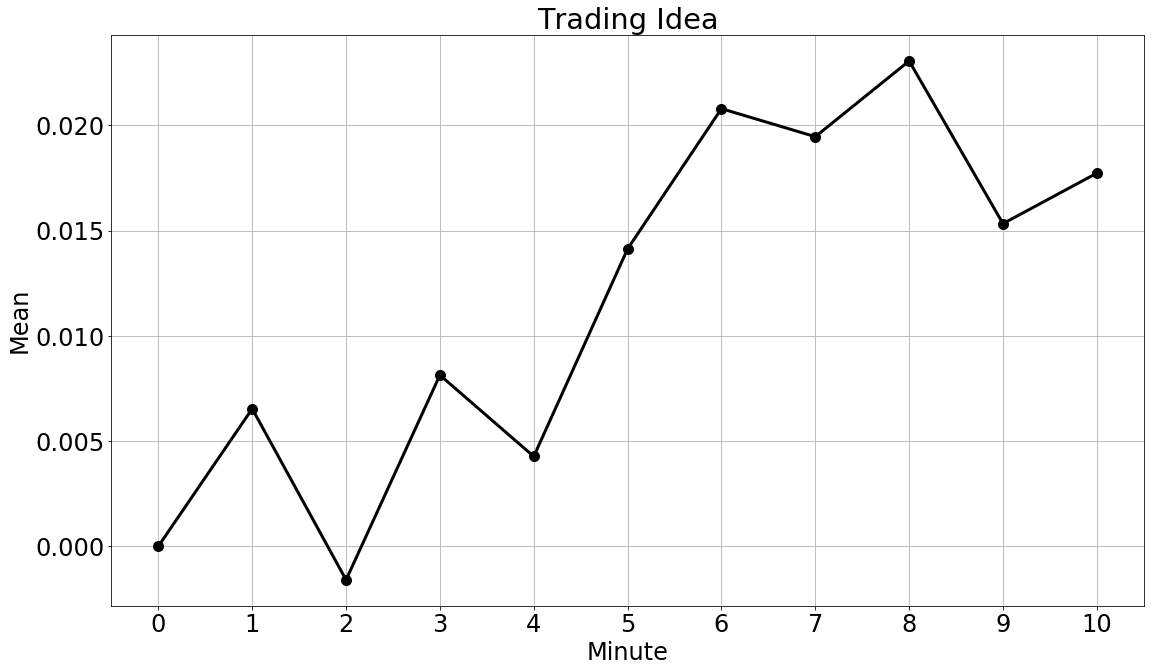

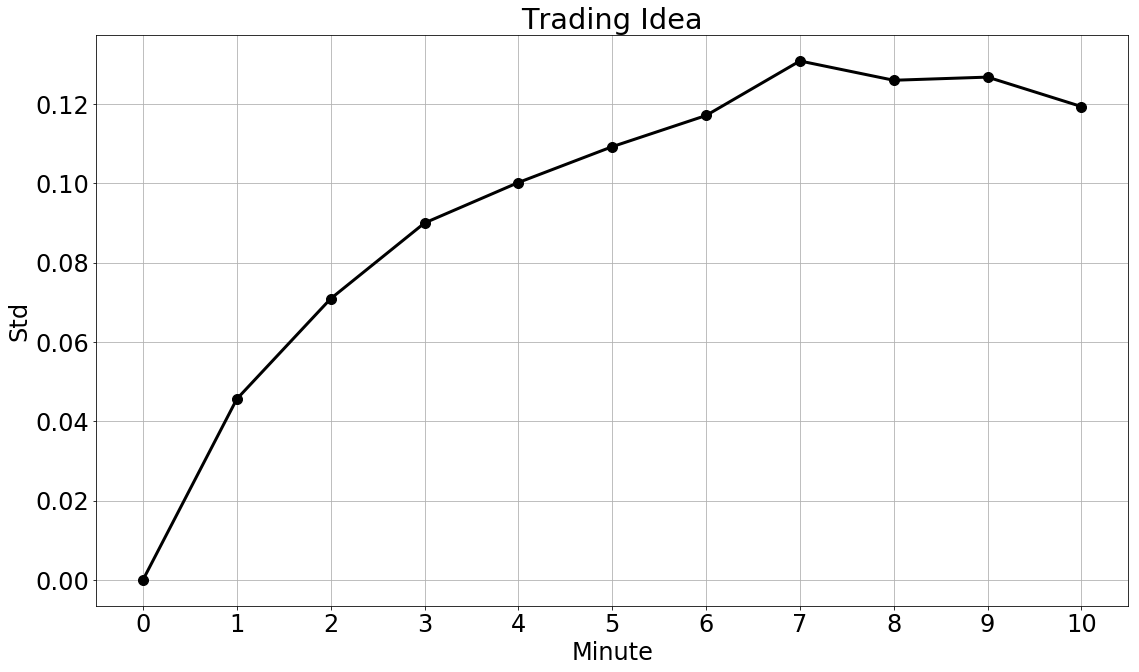

In [0]:
# use quant function and don't forget to rerun cell with functions before run this---->
Sells, Buys = quant(case_prices=case_prices, case_times=case_times, case_dates=case_dates, case_ix=case_ix, type_dir='SELL')

In [0]:
Sells

,1 minute,2 minute,3 minute,4 minute,5 minute,6 minute,7 minute,8 minute,9 minute,10 minute
Sells,386.0,360.0,305.0,252.0,317.0,314.0,267.0,224.0,167.0,282.0


In [0]:
Buys

,1 minute,2 minute,3 minute,4 minute,5 minute,6 minute,7 minute,8 minute,9 minute,10 minute
Buys,492.0,379.0,274.0,487.0,383.0,364.0,387.0,226.0,168.0,323.0


# Results

As it shows, the 8 minute is the most profitable, but it has few sells, and buys incontrast to 1 minute.